In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D 
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

In [3]:
from scipy.special import j0
from scipy.stats import binned_statistic

In [4]:
rad_to_arcsec = 3600 * 180 / np.pi

In [5]:
def deproject(u, v, Re, Im, inc, pa, dRa, dDec, inverse=False):
    '''
    Deprojects or projects visibilities
    '''
    # Convert to radian
    pa  = pa  * np.pi / 180.
    inc = inc * np.pi / 180.
    dDec *= np.pi / (180. * 3600)
    dRa  *= np.pi / (180. * 3600)
    # Correct the phase position by dRA and dDec
    if not inverse:
        Intensity = (Re + Im * 1j) * np.exp(2j * np.pi * (u * -dRa + v * -dDec))
        # Calculate deprojected arrays
        Rep = np.real(Intensity)
        Imp = np.imag(Intensity)
    # Calculate transformation
    cos_t = np.cos(pa)
    sin_t = np.sin(pa)
    aux = 1.
    if inverse:
        sin_t *= -1.
        aux = 1. / np.cos(inc)
    up = u * aux * cos_t - v * sin_t
    vp = u * aux * sin_t + v * cos_t
    #   Deproject
    if not inverse:
        up *= np.cos(inc)
    if inverse:
        Intensity = (Re + Im * 1j) * np.exp(2j * np.pi * (up * -dRa + vp * -dDec))
        # Calculate deprojected arrays
        Rep = np.real(Intensity)
        Imp = np.imag(Intensity)
    # Return
    return up, vp, Rep, Imp


In [6]:
def get_radial_profile(frank_object):
    x_ = frank_object._FT._x*rad_to_arcsec
    y_ = frank_object._FT._y*rad_to_arcsec
    x, y = np.meshgrid(x_, y_, indexing='ij')
    pixel_size = (x[1]-x[0])[0]
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

In [7]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 3 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

In [8]:
# Deprojection
du, dv, dRe, dIm = deproject(u=u, v=v, Re=Re, Im=Imag,
                             inc=inc, pa=pa, dRa=dra, dDec=ddec,
                             inverse=False)
baseline = np.sqrt(du**2 + dv**2)

In [9]:

dRe_deltaR = np.median(dRe[np.where(baseline<3e4)])*np.real(j0(2.*np.pi*(Rout/rad_to_arcsec/2.)*baseline))

In [10]:
#plt.plot(baseline, ReV)
#plt.show()

In [11]:
u = du
v = dv
Re = dRe_deltaR
Imag = np.zeros(len(Re))

In [12]:
Vis = Re + Imag*1j

In [13]:
l = 1e4
m = -0.33
c = -0.1

In [17]:
N = 300

In [18]:
frank2d = Frank2D(N, Rout)
frank2d.fit(u, v, Re, Weights, kernel_params=[m, c, l], method = 'cg', rtol = '1e-12')

Gridding...
  --> time = 0.00  min |  0.28 seconds
Setting fit with cg ...
Fitting...
  *  Constructing linear operators...
     --> time = 16.83  min |  1010.00 seconds
  *  Solving linear system...
rtol:  1e-12
atol:  0.0
rtol:  9.98003617050994e-07
final atol:  9.98003617050994e-07
maxiter:  20
iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
  --> CGM converged in  11  iterations
     --> time = 116.33  min |  6979.96 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                                !!!!!!!!!!!      fit correctly       !!!!!!!!
Inverting with 2fft ...
  --> time = 0.00  min |  0.01 seconds


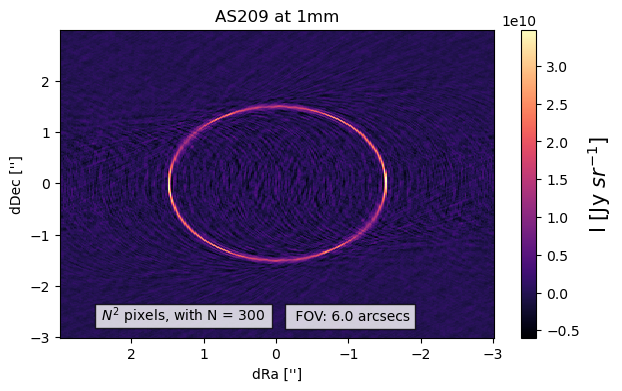

In [19]:
Plot(frank2d).get_image('AS209 at 1mm')

In [20]:
r, I = get_radial_profile(frank2d)

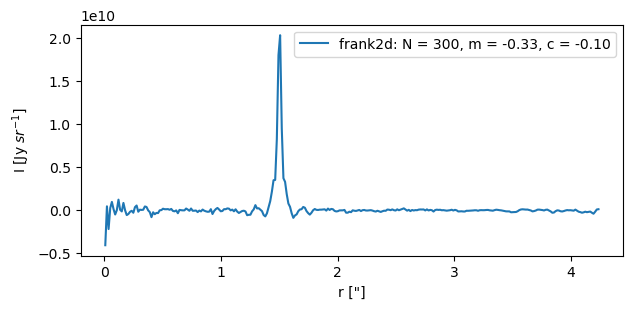

In [21]:
plt.figure(figsize=(7,3))
plt.plot(r, I, label = f'frank2d: N = {N}, m = {m:.2f}, c = {c:.2f}')
plt.xlabel('r ["]')
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.show()

In [22]:
def gauss(r, sigma):
    return np.exp(-0.5*((r-Rout/2.)/sigma)**2)

from scipy.optimize import curve_fit
popt, cov = curve_fit(gauss, r, I/np.max(I), p0=[0.09])
FWHM = popt[0]* 2. *np.sqrt(2.*np.log(2.))
Error_FWHM = np.sqrt(cov[0][0])* 2. *np.sqrt(2.*np.log(2.)) 

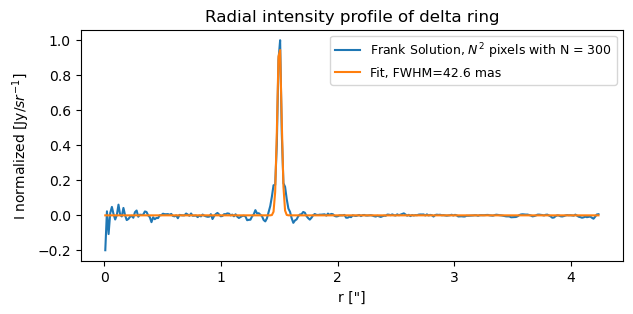

In [23]:
plt.close()
plt.figure(figsize=(7,3))
plt.plot(r, I/np.max(I), color='C0',label= r'Frank Solution, $N^{2}$ pixels with N = ' + str(N))
plt.plot(r, gauss(r, *popt), color='C1', label='Fit, FWHM=%.1f mas'%(FWHM*1000))
plt.ylabel(r'I normalized [Jy/$sr^{-1}$]')
plt.xlabel('r ["]')
plt.title('Radial intensity profile of delta ring')
plt.legend(loc='best', fontsize = 9)

In [24]:
print ('FWHM=', FWHM, '+/-', Error_FWHM, 'arcsec')   

FWHM= 0.04260472904644158 +/- 0.0007666715017605284 arcsec
